# Markov Chains - Serial patient data
## Aim
Frame the allele dynamics in the patient dataset as a Markov process. This should allow me to describe the overall dynamics with a handful of probabilities. It should also allow me to compare the dynamics of synonymous and nonsynonymous mutations independently of dN/dS assumptions.

## Allele stability analysis

The presence or absence of a variant at a given time point can be thought of as a Markov process.

### States:
- Detected (D)
- Not detected (ND)

### Transitions:
- D->D
- D->ND
- ND->ND
- ND->D

I wrote the <strong>transition_matrix_PA()</strong> function to calculate the transitions. 

What it does is:
- generates a boolean matrix for allele presence,
- multiplies [:,:-1] by 2 and subtracts from it [:,1:]
- Counts the instances of 2,1,0 and -1 which correspond to D->ND, D->D, ND->ND and ND->D transitions respectively.

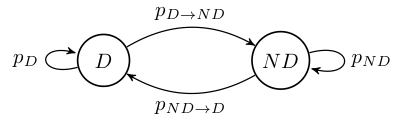

In [1]:
from IPython.display import Image
fig = Image(filename=('../references/150721_MC_qy_simple.png'))
fig

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")

#Additional Python packages
import tqdm

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [2]:
#FIGURE DETAILS
tick_size = 8
label_size = 10
title_size = 10
text_size = 8
single_column_figure = (3.35,3.35)
double_column_figure_r = (6.69,5)
double_column_figure_s = (6.69,6.69)

In [2]:
#LOAD FUNCTIONS
%cd '../src/data/'
import serial_functions as serf
%cd '../../notebooks'

#LOAD DATA
INTERIM_PATH = '../data/interim/'
PROCESSED_PATH = '../data/processed/'
OLD_PROJECT_PATH = '../../150306_Qingyun_serial/git/data/'

#PATIENT_DATA = pickle.load(open('{}2_patient_data.pkl'.format(INTERIM_PATH),'rb'))
PATIENT_DATA = pickle.load(open('{}ALLELE_info.pkl'.format(PROCESSED_PATH),'rb'))
ANNOTATION_DICT = pickle.load(open('{}2_unfixed_annotation.pkl'.format(INTERIM_PATH),'rb'))
FIXED_ANNOTATION_DICT = pickle.load(open('{}2_fixed_annotation.pkl'.format(INTERIM_PATH),'rb'))
DATA_DICT = pickle.load(open('{}2_unfixed_mutations.pkl'.format(INTERIM_PATH),'rb'))
FIXED_ARRAY = pickle.load(open('{}2_fixed_mutations.pkl'.format(INTERIM_PATH),'rb'))
ALL = pd.read_csv('{}ALLELE_data.csv'.format(PROCESSED_PATH), index_col=0)


/Users/Zuco/Documents/Work/BC2_home/160803_serial_deepseq/src/data
/Users/Zuco/Documents/Work/BC2_home/160803_serial_deepseq/notebooks


In [5]:
#Perform MC calculations and collate the results
MC_output = {'TRANSITION': [],
             'SNP_TYPE': [],
             'MEAN': [],
             '95CI_LOWER': [],
             '95CI_UPPER': [],
             'NON_EFFICACIOUS': [],
             'COUNT': []
            }

#Save the bootstrap calculations for permutation tests
MC_bootstraps = {0: {1:{}, 0:{}, 2:{}, -1:{}}, 
                 1: {1:{}, 0:{}, 2:{}, -1:{}}
            }

#lambda utility function to calculate probabilities for a given transition
transf = lambda x,pos,ind,dn: float(x[pos][ind])/np.sum([x[pos][y] for y in dn])


#Perform the analyses for efficaciously and non-efficaciously treated patients)
for patient_type,patient_set in {0:[0,1,2,3,5,6,8,9],1:[4,7,10,11]}.items():
    print('Combined data, inefficacious treatment:{}'.format(patient_type))
    ###COMBINED###
    trans_NS = np.concatenate(tuple(serf.MC_PA_CI(PATIENT_DATA['UNFIXED_ARRAYS'][ind], 
                                             ANNOTATION_DICT,
                                             exclude=PATIENT_DATA['MISSING'][ind]) for ind in patient_set))    
    MC_PA_trials = np.array([[Counter(sku.resample(trans_NS, random_state=trial)).get(x,0) for x in [0,1,2,-1]]\
                             for trial in range(1000)])
    MC_PA_numerators = np.mean(MC_PA_trials, axis=0)
    MC_PA_denominators = np.mean(MC_PA_trials, axis=0) + np.array([np.mean(MC_PA_trials, axis=0)[y] for y in [3,2,1,0]])
    MC_PA_means = MC_PA_numerators/MC_PA_denominators
    PA_transition_labels = ['0->0','1->1', '1->0', '0->1']

    dns = [[0,3],[1,2],[1,2],[0,3]]
    _tmp_rsl = []
    for ind in [1,2,-1,0]:
        _prs = [transf(MC_PA_trials,x,ind,dns[ind]) for x in range(1000)]
        CI_L, CI_H = np.argsort(_prs)[[24,975]] #95% CI indices
        MC_output['TRANSITION'].append(PA_transition_labels[ind])
        MC_output['SNP_TYPE'].append('COMBINED')
        MC_output['MEAN'].append(MC_PA_means[ind])
        MC_output['95CI_LOWER'].append(_prs[CI_L])
        MC_output['95CI_UPPER'].append(_prs[CI_H])
        MC_output['COUNT'].append(Counter(trans_NS).get(ind,0))
        MC_output['NON_EFFICACIOUS'].append(patient_type)
        print('Pr({0}) is {1:4.3f} ({2:4.3f}-{3:4.3f})'.format(PA_transition_labels[ind],MC_PA_means[ind], _prs[CI_L], _prs[CI_H]))


    ###SYNONYMOUS###
    print('Synonymous data, inefficacious treatment:{}'.format(patient_type))
    trans_NS = np.concatenate(tuple(serf.MC_PA_CI(PATIENT_DATA['UNFIXED_ARRAYS'][ind], 
                                             ANNOTATION_DICT,
                                             exclude=PATIENT_DATA['MISSING'][ind],
                                             mutation_type='synonymous') for ind in patient_set))    
    MC_PA_trials = np.array([[Counter(sku.resample(trans_NS, random_state=trial)).get(x,0) for x in [0,1,2,-1]]\
                             for trial in range(1000)])
    MC_PA_numerators = np.mean(MC_PA_trials, axis=0)
    MC_PA_denominators = np.mean(MC_PA_trials, axis=0) + np.array([np.mean(MC_PA_trials, axis=0)[y] for y in [3,2,1,0]])
    MC_PA_means = MC_PA_numerators/MC_PA_denominators
    PA_transition_labels = ['0->0','1->1', '1->0', '0->1']

    dns = [[0,3],[1,2],[1,2],[0,3]]
    _tmp_rsl = []
    for ind in [1,2,-1,0]:
        _prs = [transf(MC_PA_trials,x,ind,dns[ind]) for x in range(1000)]
        CI_L, CI_H = np.argsort(_prs)[[24,975]] #95% CI indices
        MC_output['TRANSITION'].append(PA_transition_labels[ind])
        MC_output['SNP_TYPE'].append('SYN')
        MC_output['MEAN'].append(MC_PA_means[ind])
        MC_output['95CI_LOWER'].append(_prs[CI_L])
        MC_output['95CI_UPPER'].append(_prs[CI_H])
        MC_output['COUNT'].append(Counter(trans_NS).get(ind,0))
        MC_output['NON_EFFICACIOUS'].append(patient_type)
        print('Pr({0}) is {1:4.3f} ({2:4.3f}-{3:4.3f})'.format(PA_transition_labels[ind],MC_PA_means[ind], _prs[CI_L], _prs[CI_H]))
        MC_bootstraps[patient_type][ind]['SYN'] = _prs

    ###NON-SYNONYMOUS###
    print('Non-synonymous data, inefficacious treatment:{}'.format(patient_type))
    trans_NS = np.concatenate(tuple(serf.MC_PA_CI(PATIENT_DATA['UNFIXED_ARRAYS'][ind], 
                                             ANNOTATION_DICT,
                                             exclude=PATIENT_DATA['MISSING'][ind],
                                             mutation_type='nonsynonymous') for ind in patient_set))    
    MC_PA_trials = np.array([[Counter(sku.resample(trans_NS, random_state=trial)).get(x,0) for x in [0,1,2,-1]]\
                             for trial in range(1000)])
    MC_PA_numerators = np.mean(MC_PA_trials, axis=0)
    MC_PA_denominators = np.mean(MC_PA_trials, axis=0) + np.array([np.mean(MC_PA_trials, axis=0)[y] for y in [3,2,1,0]])
    MC_PA_means = MC_PA_numerators/MC_PA_denominators
    PA_transition_labels = ['0->0','1->1', '1->0', '0->1']

    dns = [[0,3],[1,2],[1,2],[0,3]]
    _tmp_rsl = []
    for ind in [1,2,-1,0]:
        _prs = [transf(MC_PA_trials,x,ind,dns[ind]) for x in range(1000)]
        CI_L, CI_H = np.argsort(_prs)[[24,975]] #95% CI indices
        MC_output['TRANSITION'].append(PA_transition_labels[ind])
        MC_output['SNP_TYPE'].append('NSY')
        MC_output['MEAN'].append(MC_PA_means[ind])
        MC_output['95CI_LOWER'].append(_prs[CI_L])
        MC_output['95CI_UPPER'].append(_prs[CI_H])
        MC_output['COUNT'].append(Counter(trans_NS).get(ind,0))
        MC_output['NON_EFFICACIOUS'].append(patient_type)
        print('Pr({0}) is {1:4.3f} ({2:4.3f}-{3:4.3f})'.format(PA_transition_labels[ind],MC_PA_means[ind], _prs[CI_L], _prs[CI_H]))
        MC_bootstraps[patient_type][ind]['NSY'] = _prs

Combined data, inefficacious treatment:0
Pr(1->1) is 0.197 (0.135-0.257)
Pr(1->0) is 0.803 (0.743-0.865)
Pr(0->1) is 0.309 (0.257-0.361)
Pr(0->0) is 0.691 (0.639-0.743)
Synonymous data, inefficacious treatment:0
Pr(1->1) is 0.297 (0.194-0.417)
Pr(1->0) is 0.703 (0.583-0.806)
Pr(0->1) is 0.354 (0.250-0.458)
Pr(0->0) is 0.646 (0.542-0.750)
Non-synonymous data, inefficacious treatment:0
Pr(1->1) is 0.120 (0.060-0.189)
Pr(1->0) is 0.880 (0.811-0.940)
Pr(0->1) is 0.298 (0.233-0.361)
Pr(0->0) is 0.702 (0.639-0.767)
Combined data, inefficacious treatment:1
Pr(1->1) is 0.290 (0.231-0.353)
Pr(1->0) is 0.710 (0.647-0.769)
Pr(0->1) is 0.259 (0.222-0.299)
Pr(0->0) is 0.741 (0.701-0.778)
Synonymous data, inefficacious treatment:1
Pr(1->1) is 0.328 (0.212-0.458)
Pr(1->0) is 0.672 (0.542-0.788)
Pr(0->1) is 0.258 (0.172-0.340)
Pr(0->0) is 0.742 (0.660-0.828)
Non-synonymous data, inefficacious treatment:1
Pr(1->1) is 0.317 (0.244-0.396)
Pr(1->0) is 0.683 (0.604-0.756)
Pr(0->1) is 0.250 (0.198-0.301)
Pr

In [6]:
MC_df = pd.DataFrame(MC_output)

In [7]:
MC_df

,95CI_LOWER,95CI_UPPER,COUNT,MEAN,NON_EFFICACIOUS,SNP_TYPE,TRANSITION
0,0.134831,0.256545,35,0.196646,0,COMBINED,1->1
1,0.743455,0.865169,145,0.803354,0,COMBINED,1->0
2,0.256881,0.361446,101,0.308812,0,COMBINED,0->1
3,0.638554,0.743119,226,0.691188,0,COMBINED,0->0
4,0.193548,0.416667,18,0.297399,0,SYN,1->1
5,0.583333,0.806452,43,0.702601,0,SYN,1->0
6,0.250000,0.458333,28,0.353673,0,SYN,0->1
7,0.541667,0.750000,51,0.646327,0,SYN,0->0
8,0.060000,0.188889,11,0.120194,0,NSY,1->1
9,0.811111,0.940000,82,0.879806,0,NSY,1->0


In [9]:
MC_df.to_csv('../data/interim/4_MC_patients.csv')

In [4]:
MC_df = pd.read_csv('../data/interim/4_MC_patients.csv', index_col=0)

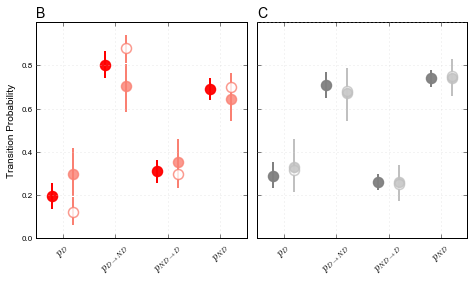

In [12]:
plt.figure('MC_paper',figsize=(6.69,4))
subf = 0
fc = [('red','salmon'),('gray','silver'),('red','salmon'),('gray','silver')]
ttl = ['B','C',]
for patient_type in [0,1]:
    _fc = fc[subf]
    _data = MC_df[(MC_df.NON_EFFICACIOUS==patient_type)]
    plt.subplot(1,2,subf+1)
    plt.vlines(np.arange(-.2,3.5,1), _data['95CI_LOWER'][_data.SNP_TYPE=='COMBINED'], 
               _data['95CI_UPPER'][_data.SNP_TYPE=='COMBINED'], color=_fc[0], lw=2)
    plt.vlines(np.arange(.2,3.5,1), _data['95CI_LOWER'][_data.SNP_TYPE=='NSY'], 
               _data['95CI_UPPER'][_data.SNP_TYPE=='NSY'], color=_fc[1], lw=2)
    plt.vlines(np.arange(.2,3.5,1), _data['95CI_LOWER'][_data.SNP_TYPE=='SYN'], 
               _data['95CI_UPPER'][_data.SNP_TYPE=='SYN'], color=_fc[1], lw=2)
    plt.plot(np.arange(.2,3.5,1), _data.MEAN[_data.SNP_TYPE=='NSY'],
             'o', label='NSY',ms=10, mec=_fc[1], mfc='white', mew=1.5,alpha=0.8)
    plt.plot(np.arange(.2,3.5,1), _data.MEAN[_data.SNP_TYPE=='SYN'],
             'o', label='SYN',ms=10, mec=_fc[1], mfc=_fc[1], mew=1.5,alpha=0.8)
    #plt.legend(loc=4, ncol=2, fontsize=14)
    plt.plot(np.arange(-.2,3.5,1), _data.MEAN[_data.SNP_TYPE=='COMBINED'],
             'o', label='ALL', ms=10, mec=_fc[0], mfc=_fc[0], mew=1.5,alpha=0.95)
    plt.xticks(range(4),[], size=tick_size)
    #plt.title('%s, %s' %(patient_type, cutoff), size=18)
    plt.title(ttl[subf], size=14, loc='left')
    plt.yticks(np.arange(0,1.2,0.2),[],size=tick_size)
    if subf == 0: 
        plt.ylabel('Transition Probability',size=label_size)
        plt.yticks(np.arange(0,1,0.2),np.arange(0,1,0.2),size=tick_size)
    plt.grid(color='lightgray')
    #plt.xlabel('Transition',size=18)
    #plt.xticks(range(4), ['Stable', 'Loss', 'Gain', 'Absent'], size=12, rotation=45)
    plt.xticks(range(4), [r'$p_D$', r'$p_{D\rightarrow ND}$', 
                          r'$p_{ND\rightarrow D}$', r'$p_{ND}$'], 
               size=label_size, rotation=45)
    subf+=1
plt.tight_layout()

plt.savefig('../reports/figures/4_MC_treatment.pdf')
#plt.savefig('../reports/figures/4_MC_treatment.png', dpi=300)

## Conclusions
1. Majority of alleles are unstable over time. This effect is more pronunced in Efficaciously treated patients.
2. In efficaciously treated patients, alleles carrying nonsynonymous mutations are less stable than synonymous ones. 

Overall, majority of genetic diversity is driven by transient low frequency alleles. In the case where the bacterial populations are exposed to at least 4 effective drugs, there is a clear disparity in the stability of alleles - nonsynonymous mutations are less stable than synonymous ones.